In [1]:
from matplotlib import pyplot
from math import pi
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import numba
from numba import jit

In [2]:
def uex(t,X,Y):
    return -numpy.exp(-2*t)*numpy.cos(X)*numpy.sin(Y)

def vex(t,X,Y):
    return numpy.exp(-2*t)*numpy.sin(X)*numpy.cos(Y)

def pex(t,X,Y):
    return -numpy.exp(-4*t)/4.*(numpy.cos(2*X)+numpy.cos(2*Y))

In [3]:
def Fc1(u,v,dx,dy):
    F=numpy.zeros(numpy.shape(u))
    F[1:-1,1:-1]=-((u[1:-1,1:-1]+u[1:-1,2:])**2-(u[1:-1,1:-1]+u[1:-1,:-2])**2)/(4*dx)-\
                ((u[1:-1,1:-1]+u[2:,1:-1])*(v[1:-1,2:]+v[1:-1,1:-1])-(u[1:-1,1:-1]+u[:-2,1:-1])*(v[:-2,2:]+v[:-2,1:-1]))/(4*dy)
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [4]:
def Fv1(u,v,dx,dy):
    F=numpy.zeros(numpy.shape(u))
    F[1:-1,1:-1]=(u[1:-1,2:]-2*u[1:-1,1:-1]+u[1:-1,:-2])/dx**2+(u[2:,1:-1]-2*u[1:-1,1:-1]+u[:-2,1:-1])/dy**2
    
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [5]:
def Fp1(p,dx,dy):
    F=numpy.zeros(numpy.shape(p))
    F[1:-1,1:-1]=-(p[1:-1,2:]-p[1:-1,1:-1])/dx
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [6]:
def Fc2(u,v,dx,dy):
    F=numpy.zeros((numpy.shape(u)))
    F[1:-1,1:-1]=-((u[2:,1:-1]+u[1:-1,1:-1])*(v[1:-1,1:-1]+v[1:-1,2:])-(u[2:,:-2]+u[1:-1,:-2])*(v[1:-1,1:-1]+v[1:-1,:-2]))/(4*dx)-\
                 ((v[1:-1,1:-1]+[v[2:,1:-1]])**2-(v[1:-1,1:-1]+v[:-2,1:-1])**2)/(4*dy)
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [7]:
def Fv2(u,v,dx,dy):
    F=numpy.zeros((numpy.shape(u)))
    F[1:-1,1:-1]=(v[1:-1,2:]-2*v[1:-1,1:-1]+v[1:-1,:-2])/dx**2+(v[2:,1:-1]-2*v[1:-1,1:-1]+v[:-2,1:-1])/dy**2
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [8]:
def Fp2(p,dx,dy):
    F=numpy.zeros((numpy.shape(p)))
    F[1:-1,1:-1]=-(p[2:,1:-1]-p[1:-1,1:-1])/dy
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [9]:
@jit
def poisson(f,res_target,omega):
    nj,ni=numpy.shape(f)-numpy.array((1,1))
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    
    p=numpy.zeros(numpy.shape(f))
    res=numpy.zeros(numpy.shape(f))
    
    res_max=1e3
    n=0
    while res_max>res_target:
        
        for j in range(1,nj):
            for i in range(1,ni):
                p[j,i]=omega/(2*(dx**2+dy**2))*((p[j,i-1]+p[j,i+1])*dy**2+\
                       (p[j-1,i]+p[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*p[j,i]
        p[0,:]=p[1,:]
        p[-1,:]=p[-2,:]
        p[:,0]=p[:,1]
        p[:,-1]=p[:,-2]
        n+=1
        
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(p[j,i-1]-2*p[j,i]+p[j,i+1])/dx**2-\
                                  (p[j-1,i]-2*p[j,i]+p[j+1,i])/dy**2)
        res_max=numpy.max(res)
    
    return p

In [10]:
@jit
def getuv(w1,w2,p,dx,dy,dt):
    u=w1+Fp1(p,dx,dy)*dt
    v=w2+Fp2(p,dx,dy)*dt
    
    u[0,:]=-u[1,:]
    u[-1,:]=-u[-2,:]
    u[:,0]=u[:,-2]
    u[:,-1]=u[:,1]

    v[0,:]=v[-2,:]
    v[-1,:]=v[1,:]
    v[:,0]=-v[:,1]
    v[:,-1]=-v[:,-2]
    return u,v

In [11]:
@jit
def error(p,p_ex):
    nj,ni=numpy.shape(p)-numpy.array((1,1))
    err=numpy.zeros(numpy.shape(p))
    for j in range(nj+1):
        for i in range(ni+1):
            err[j,i]=numpy.abs(p[j,i]-p_ex[j,i])
    err_max=numpy.mean(err[2:-2,2:-2])
    return err_max

In [12]:
@jit
def RK3(ni,nj,dt):
    T=2.
    nt=int(T/dt)
    t=0.
    dx=2.*pi/(ni-1)
    dy=2.*pi/(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    xu=numpy.linspace(0,2*pi+dx,ni+1)
    yu=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    xv=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    yv=numpy.linspace(0,2*pi+dy,nj+1)

    X,Y=numpy.meshgrid(x,y)
    Xu,Yu=numpy.meshgrid(xu,yu)
    Xv,Yv=numpy.meshgrid(xv,yv)

    u0=uex(0,Xu,Yu)
    v0=vex(0,Xv,Yv)
    p0=pex(0,X,Y)
            
    u=u0.copy()
    v=v0.copy()
    p=p0.copy()
    res=numpy.zeros((nj+1,ni+1))
    nt=0
    
    while t<T:
        G1=numpy.zeros((nj+1,ni+1))
        G2=numpy.zeros((nj+1,ni+1))
        w1=numpy.zeros((nj+1,ni+1))
        w2=numpy.zeros((nj+1,ni+1)) 
        f=numpy.zeros((nj+1,ni+1))
        
        #from t to t+dt/3
        t+=dt/3
        G1=Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt/3*G1
        w2=v+dt/3*G2
        f[1:-1,1:-1]=3./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1e-9,1.99)
        u,v=getuv(w1,w2,p,dx,dy,dt/3)
        
        #from t+dt/3 to t+3dt/4
        t+=5./12*dt
        G1=-5./9*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-5./9*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*15./16*G1
        w2=v+dt*15./16*G2
        f[1:-1,1:-1]=12./5/dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)        
        p=poisson(f,1e-9,1.99)
        u,v=getuv(w1,w2,p,dx,dy,5.*dt/12)
        
        #from t+3dt/4 to t+dt
        t+=dt/4
        G1=-153./128*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-153./128*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*8./15*G1
        w2=v+dt*8./15*G2
        f[1:-1,1:-1]=4./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1e-9,1.99)
        u,v=getuv(w1,w2,p,dx,dy,dt/4)
        
        if (nt)%100==0:
            print(error(u,uex(t,Xu,Yu)),error(v,vex(t,Xv,Yv)),error(p,pex(t,X,Y)))
        nt+=1
    
    A=numpy.array([u,v,p])
    return A

In [13]:
def grid_p(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    return X,Y

def grid_u(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    xu=numpy.linspace(0,2*pi+dx,ni+1)
    yu=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(xu,yu)
    return X,Y

def grid_v(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    xv=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    yv=numpy.linspace(0,2*pi+dy,nj+1)
    X,Y=numpy.meshgrid(xv,yv)
    return X,Y

In [14]:
X,Y=grid_p(21,21)
Xu,Yu=grid_u(21,21)
Xv,Yv=grid_v(21,21)

In [15]:
A1_1=RK3(21,21,0.004)
u_err=error(A1_1[0],uex(2,Xu,Yu))
v_err=error(A1_1[1],vex(2,Xv,Yv))
p_err=error(A1_1[2],pex(2,X,Y))
    
print('u error={}'.format(u_err))
print('v error={}'.format(v_err))
print('p error={}'.format(p_err))

2.67385464352e-05 2.67385464363e-05 0.207224179624
0.00121744248212 0.00121744248212 0.0425288127449
0.00109222968673 0.00109222968673 0.00872776596717
0.000737355309407 0.000737355309408 0.00179101974569
0.000442841835803 0.000442841835804 0.000367515396513
u error=0.00025091684696500725
v error=0.00025091684696403505
p error=7.66139015564465e-05


In [16]:
A1_2=RK3(21,21,0.002)
u_err=error(A1_2[0],uex(2,Xu,Yu))
v_err=error(A1_2[1],vex(2,Xv,Yv))
p_err=error(A1_2[2],pex(2,X,Y))
    
print('u error={}'.format(u_err))
print('v error={}'.format(v_err))
print('p error={}'.format(p_err))

1.34226671127e-05 1.34226671132e-05 0.208339715866
0.000910237321673 0.000910237321672 0.0943839756786
0.00121625364964 0.00121625364964 0.0427581239873
0.00122289682681 0.00122289682681 0.0193701618954
0.00109386394489 0.00109386394489 0.00877489943482
0.000917598431727 0.000917598431726 0.00397507557429
0.000739070384027 0.000739070384027 0.00180070691068
0.000578796805567 0.000578796805567 0.000815708759705
0.000444056051342 0.000444056051341 0.000369506198258
0.00033537263713 0.000335372637131 0.000167379740346
0.000250169787528 0.000250169787528 7.58191067128e-05
u error=0.00022012058912685174
v error=0.00022012058912733532
p error=7.567787509553292e-05


In [17]:
A1_3=RK3(21,21,0.001)
u_err=error(A1_3[0],uex(2,Xu,Yu))
v_err=error(A1_3[1],vex(2,Xv,Yv))
p_err=error(A1_3[2],pex(2,X,Y))
    
print('u error={}'.format(u_err))
print('v error={}'.format(v_err))
print('p error={}'.format(p_err))

6.72471638638e-06 6.7247163861e-06 0.208903151434
0.000556535048201 0.000556535048202 0.140607759477
0.00090753727879 0.000907537278789 0.094639430662
0.00111360783885 0.00111360783885 0.0636991286678
0.00121564738803 0.00121564738803 0.0428739417272
0.00124451041864 0.00124451041864 0.0288570472713
0.00122329990598 0.00122329990598 0.0194226700095
0.00116916079818 0.00116916079818 0.0130726773456
0.00109467852228 0.00109467852228 0.0087987044523
0.00100896667793 0.00100896667793 0.00592204225439
0.000918510570391 0.000918510570391 0.00398586756177
0.000827819297273 0.000827819297274 0.00268270441874
0.000739928026634 0.000739928026633 0.00180559934913
0.000656783308758 0.000656783308758 0.00121525821523
0.000579537287465 0.000579537287465 0.00081792665183
0.000508771149023 0.000508771149022 0.00055050184411
0.000444663772009 0.000444663772009 0.000370511615856
0.000387118083457 0.000387118083458 0.00024936960415
0.000335854897067 0.000335854897067 0.000167835508483
0.000290481857672 0

In [18]:
X,Y=grid_p(41,41)
Xu,Yu=grid_u(41,41)
Xv,Yv=grid_v(41,41)

In [19]:
A2_1=RK3(41,41,0.004)
u_err=error(A2_1[0],uex(2,Xu,Yu))
v_err=error(A2_1[1],vex(2,Xv,Yv))
p_err=error(A2_1[2],pex(2,X,Y))
    
print('u error={}'.format(u_err))
print('v error={}'.format(v_err))
print('p error={}'.format(p_err))

6.70082463565e-06 6.70082463557e-06 0.201859772329
0.000304348374084 0.000304348374084 0.0409059756837
0.000272374927248 0.000272374927248 0.0082893994007
0.000183425250493 0.000183425250493 0.0016798043841
0.00010989012086 0.00010989012086 0.000340403246701
u error=6.211218620832283e-05
v error=6.211218620834118e-05
p error=7.009074523041793e-05


In [20]:
A2_2=RK3(41,41,0.002)
u_err=error(A2_2[0],uex(2,Xu,Yu))
v_err=error(A2_2[1],vex(2,Xv,Yv))
p_err=error(A2_2[2],pex(2,X,Y))
    
print('u error={}'.format(u_err))
print('v error={}'.format(v_err))
print('p error={}'.format(p_err))

3.3638575059e-06 3.36385750584e-06 0.203007801676
0.000227834576285 0.000227834576285 0.0913863892377
0.000304057003128 0.000304057003128 0.0411386599249
0.000305341733464 0.000305341733464 0.018519045372
0.000272787701364 0.000272787701364 0.0083365600706
0.000228548779478 0.000228548779478 0.00375279641896
0.000183855422768 0.000183855422768 0.00168936293308
0.000143807257972 0.000143807257972 0.000760485171911
0.000110193542201 0.000110193542201 0.000342340573982
8.31207174839e-05 8.31207174839e-05 0.000154108230325
6.19269169245e-05 6.19269169245e-05 6.93734235358e-05
u error=3.187819586263717e-05
v error=3.1878195862644946e-05
p error=6.930394759409576e-05


In [21]:
A2_3=RK3(41,41,0.001)
u_err=error(A2_3[0],uex(2,Xu,Yu))
v_err=error(A2_3[1],vex(2,Xv,Yv))
p_err=error(A2_3[2],pex(2,X,Y))
    
print('u error={}'.format(u_err))
print('v error={}'.format(v_err))
print('p error={}'.format(p_err))

1.68529441906e-06 1.68529441903e-06 0.203587348866
0.000139388674376 0.000139388674376 0.136595142476
0.000227160339526 0.000227160339526 0.0916473015043
0.000278569324488 0.000278569324488 0.061489939609
0.000303907569958 0.000303907569958 0.0412561226149
0.000310931861681 0.000310931861681 0.027680422196
0.000305444518278 0.000305444518278 0.01857192704
0.000291746899636 0.000291746899636 0.0124606640158
0.000272992755364 0.000272992755364 0.008360367368
0.000251462817498 0.000251462817498 0.00560931068646
0.000228777573974 0.000228777573974 0.00376351444541
0.000206061607956 0.000206061607956 0.00252509451078
0.000184070067512 0.000184070067512 0.00169418817709
0.000163285592183 0.000163285592183 0.00113669935639
0.000143992249116 0.000143992249116 0.00076265749043
0.000126331626995 0.000126331626995 0.000511697652354
0.000110345125314 0.000110345125314 0.000343318548449
9.60055993506e-05 9.60055993506e-05 0.000230346209121
8.32408292108e-05 8.32408292108e-05 0.000154548512647
7.195

In [22]:
X,Y=grid_p(81,81)
Xu,Yu=grid_u(81,81)
Xv,Yv=grid_v(81,81)

In [23]:
A3_3=RK3(81,81,0.001)
u_err=error(A3_3[0],uex(2,Xu,Yu))
v_err=error(A3_3[1],vex(2,Xv,Yv))
p_err=error(A3_3[2],pex(2,X,Y))
    
print('u error={}'.format(u_err))
print('v error={}'.format(v_err))
print('p error={}'.format(p_err))

4.19430119226e-07 4.19430119224e-07 0.176954294435
3.46852166422e-05 3.46852166422e-05 0.118642152086
5.65174448524e-05 5.65174448524e-05 0.0795457394843
6.92973108822e-05 6.92973108822e-05 0.0533328546239
7.55888405615e-05 7.55888405615e-05 0.0357579600304
7.732402675e-05 7.732402675e-05 0.0239745595916
7.59477013942e-05 7.59477013942e-05 0.0160741693669
7.25306561295e-05 7.25306561295e-05 0.0107772123616
6.78577617774e-05 6.78577617774e-05 0.00722577342931
6.24964332724e-05 6.24964332724e-05 0.00484464810849
5.68496697555e-05 5.68496697555e-05 0.00324818034329
5.11970120225e-05 5.11970120225e-05 0.00217780017705
4.57260547157e-05 4.57260547157e-05 0.00146014478709
4.05565915734e-05 4.05565915734e-05 0.000978979988485
3.57590289356e-05 3.57590289356e-05 0.000656374507004
3.13683520004e-05 3.13683520004e-05 0.000440077935292
2.73946509953e-05 2.73946509953e-05 0.00029505805976
2.38309954383e-05 2.38309954383e-05 0.000197826910557
2.06592719715e-05 2.06592719715e-05 0.000132636561242
1.

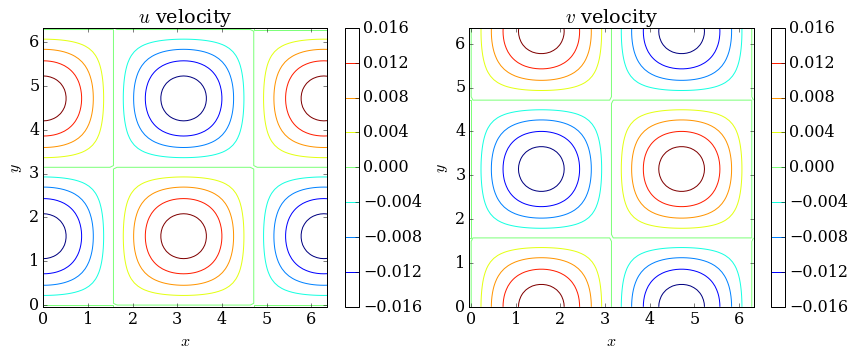

In [25]:
pyplot.figure(figsize=(14,5))
pyplot.subplot(121)
pyplot.contour(Xu,Yu,A3_3[0],10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$u$ velocity')

pyplot.subplot(122)
pyplot.contour(Xv,Yv,A3_3[1],10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$v$ velocity');

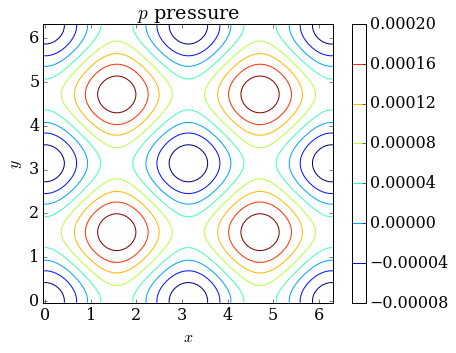

In [27]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X,Y,A3_3[2],10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$p$ pressure');